<a href="https://colab.research.google.com/github/ERKAN3806/imageModel/blob/main/chronic_periodontitis_and_Parkinson's_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.26), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GEOquery' 'limma' 'clusterProfiler'
  'org.Hs.eg.db' 'enrichplot' 'STRINGdb' 'igraph' 'pROC'”
Found 1 file(s)

GSE6613_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpPTQHEx/GSE6613_series_matrix.txt.gz

Using locally cached version of GPL96 found here:
/tmp/RtmpPTQHEx/GPL96.soft.gz 



DEG sayısı: 13515 


'select()' returned 1:many mapping between keys and columns



ROC analizi için hub gen bulunamadı.
CIBERSORT_input.txt başarıyla oluşturuldu.


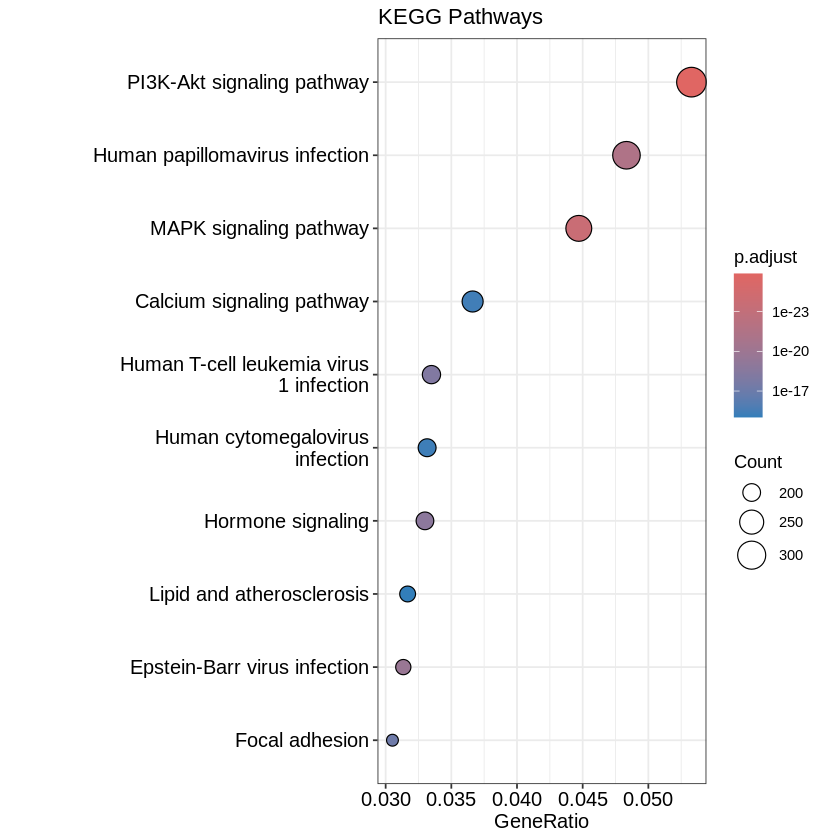

In [ ]:

# PAKETLER

if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install(c("GEOquery", "limma", "clusterProfiler", "org.Hs.eg.db",
                       "enrichplot", "STRINGdb", "igraph", "pROC"), ask = FALSE)

library(GEOquery)
library(limma)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(STRINGdb)
library(igraph)
library(pROC)


# VERİ

gse <- getGEO("GSE6613", GSEMatrix = TRUE)[[1]]
expr <- exprs(gse)
pheno <- pData(gse)
annot <- fData(gse)


pheno$group <- ifelse(grepl("Parkinson", pheno$characteristics_ch1), "disease", "control")
pheno$group <- factor(pheno$group, levels = c("control", "disease"))


expr <- normalizeBetweenArrays(log2(expr + 1))


# DEG ANALİZİ

design <- model.matrix(~ group, data = pheno)
fit <- lmFit(expr, design)
fit <- eBayes(fit)
res <- topTable(fit, coef = "groupdisease", number = Inf, adjust = "fdr")




res$ID <- rownames(res)
merged <- merge(res, annot[, c("ID", "Gene Symbol")], by = "ID")
merged <- merged[merged$`Gene Symbol` != "", ]
merged <- merged[!duplicated(merged$`Gene Symbol`), ]
deg_genes <- merged$`Gene Symbol`
cat("DEG sayısı:", length(deg_genes), "\n")




entrez_ids <- mapIds(org.Hs.eg.db, keys = deg_genes, column = "ENTREZID",
                     keytype = "SYMBOL", multiVals = "first")
entrez_ids <- na.omit(entrez_ids)


#  ZENGİNLEŞTİRME

if (length(entrez_ids) > 0) {
  go <- enrichGO(gene = entrez_ids, OrgDb = org.Hs.eg.db,
                 keyType = "ENTREZID", ont = "BP", pvalueCutoff = 0.05)
  kegg <- enrichKEGG(gene = entrez_ids, organism = "hsa", pvalueCutoff = 0.05)

  dotplot(go, showCategory = 10, title = "GO Biological Process")
  dotplot(kegg, showCategory = 10, title = "KEGG Pathways")
} else {
  cat("Zenginleştirme için yeterli Entrez ID bulunamadı.\n")
}


# HUB GENLER

hub_genes <- character(0)
string_db <- STRINGdb$new(version = "11.5", species = 9606, score_threshold = 400)
mapped <- string_db$map(data.frame(gene = deg_genes), "gene", removeUnmappedRows = TRUE)

if (nrow(mapped) > 0) {
  interactions <- string_db$get_interactions(mapped$STRING_id)
  if (!is.null(interactions) && all(c("preferredName_A", "preferredName_B") %in% names(interactions))) {
    edges <- data.frame(from = interactions$preferredName_A, to = interactions$preferredName_B)
    if (ncol(edges) >= 2 && nrow(edges) > 0) {
      g <- graph_from_data_frame(edges, directed = FALSE)
      hub_genes <- names(sort(degree(g), decreasing = TRUE))[1:min(5, vcount(g))]
      cat("Hub genler:\n")
      print(hub_genes)
    } else {
      cat("Etkileşim verisi boş veya yetersiz.\n")
    }
  } else {
    cat("STRING etkileşim alanları eksik.\n")
  }
} else {
  cat("STRING'e uygun gen eşleşmesi yapılamadı.\n")
}


# ROC ANALİZİ

if (length(hub_genes) > 0) {
  gen <- hub_genes[1]
  labels <- ifelse(pheno$group == "disease", 1, 0)
  probe <- merged$ID[merged$`Gene Symbol` == gen]
  if (length(probe) == 1) {
    roc_obj <- roc(response = labels, predictor = expr[probe, ])
    plot(roc_obj, col = "blue", print.auc = TRUE, main = paste("ROC -", gen))
  } else {
    cat("ROC için uygun prob bulunamadı.\n")
  }
} else {
  cat("ROC analizi için hub gen bulunamadı.\n")
}



write.table(expr, file = "CIBERSORT_input.txt", sep = "\t", quote = FALSE, col.names = NA)
cat("CIBERSORT_input.txt başarıyla oluşturuldu.\n")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.26), R 4.5.2 (2025-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GEOquery' 'limma' 'clusterProfiler'
  'org.Hs.eg.db' 'enrichplot' 'STRINGdb' 'igraph' 'pROC'”
Found 1 file(s)

GSE6613_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpfrFPZC/GSE6613_series_matrix.txt.gz

Using locally cached version of GPL96 found here:
/tmp/RtmpfrFPZC/GPL96.soft.gz 



Tüm örneklerin hastalık durum dağılımı:

     HC OtherND      PD 
     22      33      50 

Analizde kullanılacak örneklerin grup dağılımı (HC vs PD):

HC PD 
22 50 


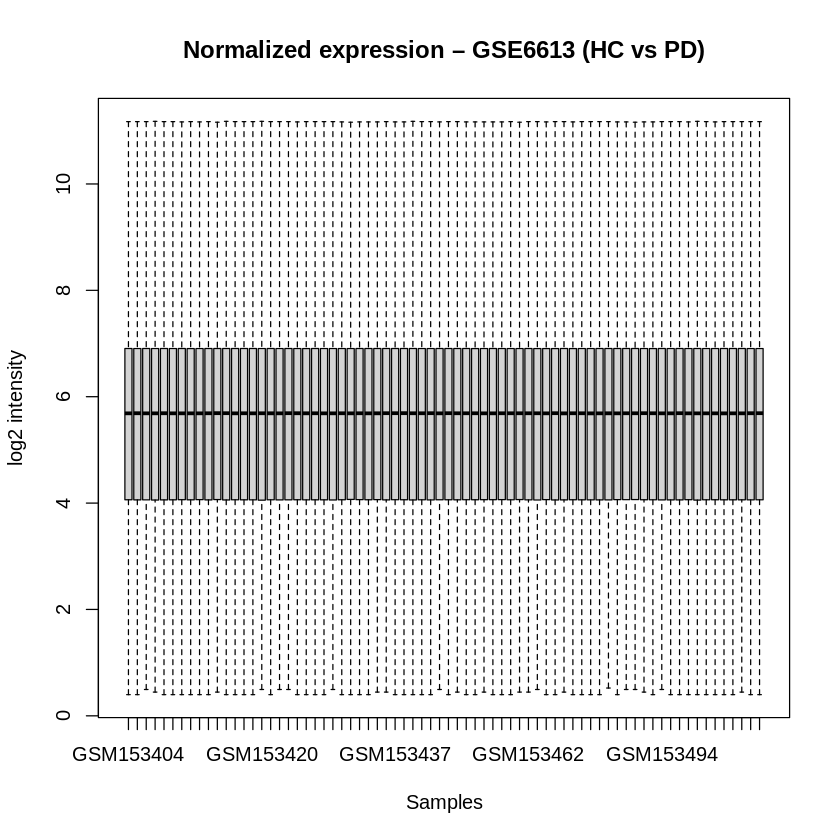


Toplam uniq gen sayısı (ID+Gene Symbol sonrası): 13515 


⚠️ adj.P.Val<0.05 & |logFC|>0.15 ile DEG bulunamadı, eşik gevşetiliyor: p<0.05 & |logFC|>0.15




Analizde kullanılacak DEG sayısı: 814 
DEG seçim etiketi:

p<0.05_&_FC>0.15 
             814 

DEG yön dağılımı (PD'de yukarı/aşağı):

Down_in_PD   Up_in_PD 
       397        417 


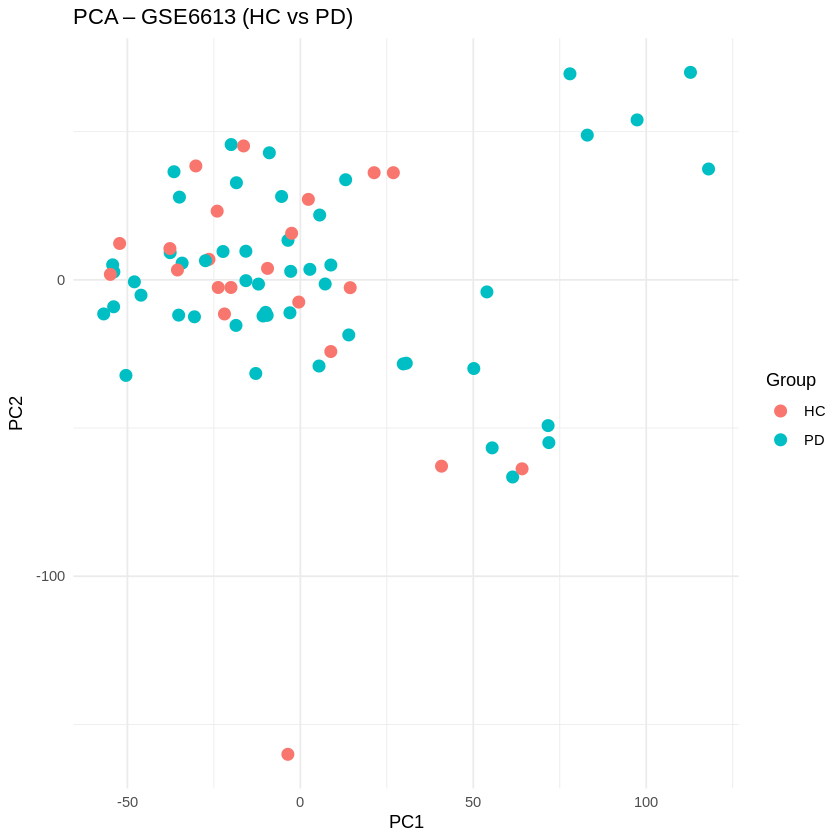

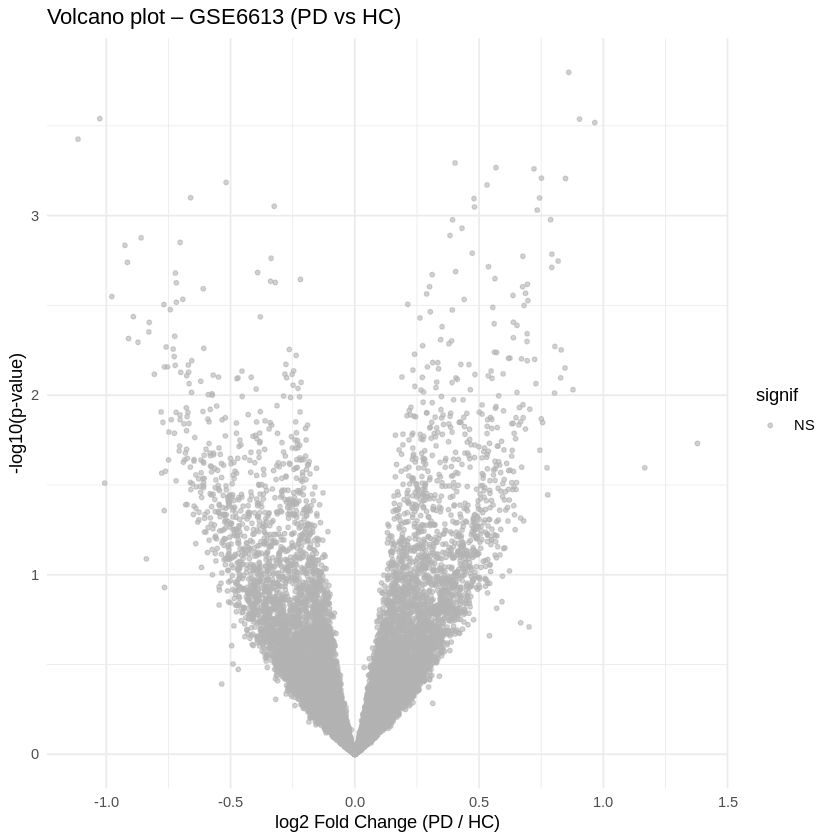

'select()' returned 1:1 mapping between keys and columns




Entrez ID’ye eşleşen gen sayısı: 718 

GO ve KEGG sonuçları kaydedildi: GO_results_GSE6613.csv, KEGG_results_GSE6613.csv
STRING'e başarıyla map edilen DEG sayısı: 738 
STRING etkileşim sayısı: 9394 
Filtrelenmiş DEG–DEG etkileşim sayısı: 0 
⚠️ DEG–DEG etkileşim bulunamadı, hub gen hesaplanamadı.

ROC analizi için hub gen bulunamadı.

CIBERSORT_input_GSE6613_PD_vs_HC.txt başarıyla oluşturuldu.

Tam sonuçlar:
  - ALL_genes_lmFit_GSE6613.csv (tüm genler)
  - DEG_used_GSE6613.csv (analizde kullanılan DEG seti)
  - GO_results_GSE6613.csv & KEGG_results_GSE6613.csv (zenginleştirme)
  - CIBERSORT_input_GSE6613_PD_vs_HC.txt (immün hücre oranı analizi için)


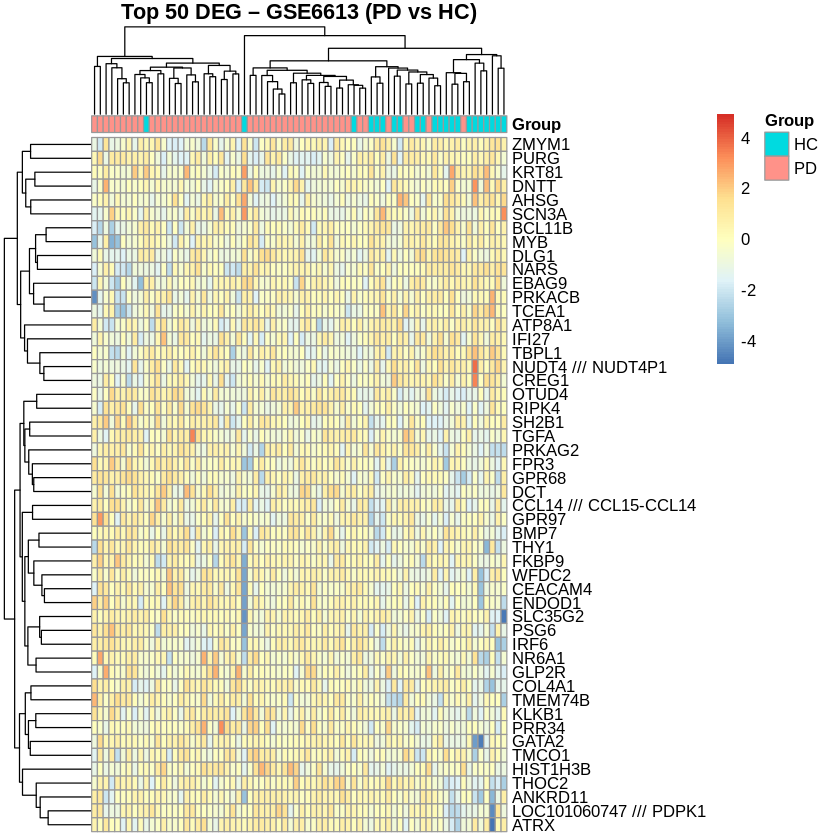

In [ ]:


## 1. PAKETLER ----
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c(
  "GEOquery", "limma", "clusterProfiler", "org.Hs.eg.db",
  "enrichplot", "STRINGdb", "igraph", "pROC"
), ask = FALSE)

if (!requireNamespace("pheatmap", quietly = TRUE))
  install.packages("pheatmap")
if (!requireNamespace("ggplot2", quietly = TRUE))
  install.packages("ggplot2")

library(GEOquery)
library(limma)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(STRINGdb)
library(igraph)
library(pROC)
library(pheatmap)
library(ggplot2)

set.seed(123)


# VERİ
gse   <- getGEO("GSE6613", GSEMatrix = TRUE)[[1]]
expr  <- exprs(gse)
pheno <- pData(gse)
annot <- fData(gse)


pheno$disease_state <- ifelse(
  grepl("Parkinson", pheno$characteristics_ch1, ignore.case = TRUE), "PD",
  ifelse(grepl("healthy", pheno$characteristics_ch1, ignore.case = TRUE), "HC",
         "OtherND")
)

cat("Tüm örneklerin hastalık durum dağılımı:\n")
print(table(pheno$disease_state))

# Sadece PD ve HC
keep_samples <- pheno$disease_state %in% c("PD", "HC")
expr  <- expr[, keep_samples]
pheno <- pheno[keep_samples, ]

pheno$group <- factor(pheno$disease_state, levels = c("HC", "PD"))
cat("\nAnalizde kullanılacak örneklerin grup dağılımı (HC vs PD):\n")
print(table(pheno$group))


# NORMALİZASYON

expr_log  <- log2(expr + 1)
expr_norm <- normalizeBetweenArrays(expr_log)


boxplot(as.data.frame(expr_norm), outline = FALSE,
        main = "Normalized expression – GSE6613 (HC vs PD)",
        xlab = "Samples", ylab = "log2 intensity")


pca <- prcomp(t(expr_norm), scale. = TRUE)
pca_df <- data.frame(
  PC1   = pca$x[, 1],
  PC2   = pca$x[, 2],
  group = pheno$group
)

ggplot(pca_df, aes(x = PC1, y = PC2, color = group)) +
  geom_point(size = 3) +
  theme_minimal() +
  labs(title = "PCA – GSE6613 (HC vs PD)",
       color = "Group")


# DEG ANALİZİ (limma)

design <- model.matrix(~ group, data = pheno)
fit    <- lmFit(expr_norm, design)
fit    <- eBayes(fit)

# PD vs HC için ilgili katsayı "groupPD"
res <- topTable(fit,
                coef   = "groupPD",
                number = Inf,
                adjust = "fdr")

res$ID <- rownames(res)


annot_sub <- annot[, c("ID", "Gene Symbol")]
merged <- merge(res, annot_sub, by = "ID")

merged <- merged[merged$`Gene Symbol` != "", ]
merged <- merged[!duplicated(merged$`Gene Symbol`), ]

cat("\nToplam uniq gen sayısı (ID+Gene Symbol sonrası):", nrow(merged), "\n")


deg_strict <- subset(merged, adj.P.Val < 0.05 & abs(logFC) > 0.15)

if (nrow(deg_strict) == 0) {
  message("⚠️ adj.P.Val<0.05 & |logFC|>0.15 ile DEG bulunamadı, eşik gevşetiliyor: p<0.05 & |logFC|>0.15")
  deg_relaxed <- subset(merged, P.Value < 0.05 & abs(logFC) > 0.15)
  if (nrow(deg_relaxed) == 0) {
    message("⚠️ p<0.05 & |logFC|>0.15 ile de DEG yok, en anlamlı 200 gen 'keşif seti' olarak alınacak.")
    deg_used <- head(merged[order(merged$adj.P.Val), ], 200)
    deg_used$DEG_flag <- "top200_by_adjP"
  } else {
    deg_used <- deg_relaxed
    deg_used$DEG_flag <- "p<0.05_&_FC>0.15"
  }
} else {
  deg_used <- deg_strict
  deg_used$DEG_flag <- "adjP<0.05_&_FC>0.15"
}

cat("\nAnalizde kullanılacak DEG sayısı:", nrow(deg_used), "\n")
cat("DEG seçim etiketi:\n")
print(table(deg_used$DEG_flag))

deg_used$direction <- ifelse(deg_used$logFC > 0, "Up_in_PD", "Down_in_PD")
cat("\nDEG yön dağılımı (PD'de yukarı/aşağı):\n")
print(table(deg_used$direction))


volc_df <- merged
volc_df$signif <- "NS"
volc_df$signif[merged$adj.P.Val < 0.05 & abs(merged$logFC) > 0.15] <- "Signif"

ggplot(volc_df, aes(x = logFC, y = -log10(P.Value), color = signif)) +
  geom_point(alpha = 0.6, size = 1) +
  scale_color_manual(values = c("grey70", "red")) +
  theme_minimal() +
  labs(title = "Volcano plot – GSE6613 (PD vs HC)",
       x = "log2 Fold Change (PD / HC)",
       y = "-log10(p-value)")


# ISI HARİTASI (TOP 50 DEG)

deg_ordered <- deg_used[order(deg_used$adj.P.Val), ]
top50 <- head(deg_ordered, 50)

expr_top50 <- expr_norm[top50$ID, ]
rownames(expr_top50) <- top50$`Gene Symbol`

ann_col <- data.frame(Group = pheno$group)
rownames(ann_col) <- rownames(pheno)

pheatmap(expr_top50,
         annotation_col = ann_col,
         scale = "row",
         show_rownames = TRUE,
         show_colnames = FALSE,
         main = "Top 50 DEG – GSE6613 (PD vs HC)")




deg_genes <- deg_used$`Gene Symbol`

entrez_ids <- mapIds(
  org.Hs.eg.db,
  keys      = deg_genes,
  column    = "ENTREZID",
  keytype   = "SYMBOL",
  multiVals = "first"
)

entrez_ids <- na.omit(entrez_ids)
cat("\nEntrez ID’ye eşleşen gen sayısı:", length(entrez_ids), "\n")


# GO & KEGG ZENGİNLEŞTİRMe

if (length(entrez_ids) > 0) {
  go_res <- enrichGO(
    gene          = entrez_ids,
    OrgDb         = org.Hs.eg.db,
    keyType       = "ENTREZID",
    ont           = "BP",
    pvalueCutoff  = 0.05,
    qvalueCutoff  = 0.2
  )

  kegg_res <- enrichKEGG(
    gene          = entrez_ids,
    organism      = "hsa",
    pvalueCutoff  = 0.05
  )


  dotplot(go_res, showCategory = 10,
          title = "GO Biological Process – GSE6613 (PD vs HC)")


  dotplot(kegg_res, showCategory = 10,
          title = "KEGG Pathways – GSE6613 (PD vs HC)")


  write.csv(as.data.frame(go_res),   "GO_results_GSE6613.csv",   row.names = FALSE)
  write.csv(as.data.frame(kegg_res), "KEGG_results_GSE6613.csv", row.names = FALSE)

  cat("\nGO ve KEGG sonuçları kaydedildi: GO_results_GSE6613.csv, KEGG_results_GSE6613.csv\n")
} else {
  cat("\n⚠️ Zenginleştirme için yeterli Entrez ID bulunamadı.\n")
}




hub_genes <- character(0)


string_db <- STRINGdb$new(
  version         = "12.0",
  species         = 9606,
  score_threshold = 300,
  input_directory = ""
)

mapped <- string_db$map(
  data.frame(gene = deg_genes),
  "gene",
  removeUnmappedRows = TRUE
)

cat("\nSTRING'e başarıyla map edilen DEG sayısı:", nrow(mapped), "\n")

if (nrow(mapped) > 1) {

  string_ids <- unique(mapped$STRING_id)

  interactions <- string_db$get_interactions(string_ids)

  if (!is.null(interactions) && nrow(interactions) > 0) {
    cat("STRING etkileşim sayısı:", nrow(interactions), "\n")


    if (all(c("preferredName_A", "preferredName_B") %in% colnames(interactions))) {
      edges <- data.frame(
        from = interactions$preferredName_A,
        to   = interactions$preferredName_B
      )
    } else if (all(c("from", "to") %in% colnames(interactions))) {
      edges <- data.frame(
        from = interactions$from,
        to   = interactions$to
      )
    } else {
      cat("⚠️ STRING etkileşim alanları beklenen formatta değil, PPI ağı kurulamadı.\n")
      edges <- NULL
    }

    if (!is.null(edges) && nrow(edges) > 0) {

      edges_f <- subset(edges,
                        from %in% mapped$gene &
                        to   %in% mapped$gene)

      cat("Filtrelenmiş DEG–DEG etkileşim sayısı:", nrow(edges_f), "\n")

      if (nrow(edges_f) > 0) {
        g <- graph_from_data_frame(edges_f, directed = FALSE)
        deg_vec <- degree(g)
        deg_vec <- sort(deg_vec, decreasing = TRUE)

        hub_genes <- names(deg_vec)[1:min(5, length(deg_vec))]
        cat("PPI tabanlı hub genler:\n")
        print(hub_genes)
      } else {
        cat("⚠️ DEG–DEG etkileşim bulunamadı, hub gen hesaplanamadı.\n")
      }
    }

  } else {
    cat("⚠️ STRING etkileşim bilgisi boş döndü.\n")
  }
} else {
  cat("⚠️ STRING için yeterli sayıda gen eşleşmedi.\n")
}


# ROC ANALİZİ

if (length(hub_genes) > 0) {
  labels <- ifelse(pheno$group == "PD", 1, 0)

  par(mfrow = c(1, min(3, length(hub_genes))))

  for (gen in hub_genes) {
    probe_ids <- merged$ID[merged$`Gene Symbol` == gen]

    if (length(probe_ids) == 0) {
      cat("ROC için prob bulunamadı (", gen, ")\n")
      next
    }


    if (length(probe_ids) > 1) {
      sub_tab <- merged[merged$ID %in% probe_ids, ]
      best_id <- sub_tab$ID[which.min(sub_tab$adj.P.Val)]
      probe_id <- best_id
    } else {
      probe_id <- probe_ids
    }

    predictor <- expr_norm[probe_id, ]
    roc_obj <- roc(response = labels, predictor = predictor)
    plot(roc_obj,
         main = paste("ROC –", gen),
         col  = "blue",
         print.auc = TRUE)
  }

  par(mfrow = c(1, 1))
} else {
  cat("\nROC analizi için hub gen bulunamadı.\n")
}




write.table(expr_norm,
            file      = "CIBERSORT_input_GSE6613_PD_vs_HC.txt",
            sep       = "\t",
            quote     = FALSE,
            col.names = NA)

cat("\nCIBERSORT_input_GSE6613_PD_vs_HC.txt başarıyla oluşturuldu.\n")



write.csv(merged,   "ALL_genes_lmFit_GSE6613.csv", row.names = FALSE)
write.csv(deg_used, "DEG_used_GSE6613.csv",        row.names = FALSE)

cat("\nTam sonuçlar:\n",
    " - ALL_genes_lmFit_GSE6613.csv (tüm genler)\n",
    " - DEG_used_GSE6613.csv (analizde kullanılan DEG seti)\n",
    " - GO_results_GSE6613.csv & KEGG_results_GSE6613.csv (zenginleştirme)\n",
    " - CIBERSORT_input_GSE6613_PD_vs_HC.txt (immün hücre oranı analizi için)\n")
